# Stock Price Prediction

## 1. Dataset Collection

I'm using yfinance which is a more reliable way to get Yahoo Finance data. The Yahoo Finance API has experienced several changes, and many people have switched to using the yfinance library

In [2]:
import yfinance as yf
import datetime

# Define the stock symbol and time range
stock_symbol = 'AAPL'
start_date = '2015-01-01'
end_date = '2024-10-01'

# Fetch the stock data using yfinance
stock_data = yf.download(stock_symbol, start=start_date, end=end_date)

# Display the first few rows of the dataset
print(stock_data.head())


[*********************100%***********************]  1 of 1 completed

Price                      Adj Close      Close       High        Low  \
Ticker                          AAPL       AAPL       AAPL       AAPL   
Date                                                                    
2015-01-02 00:00:00+00:00  24.373959  27.332500  27.860001  26.837500   
2015-01-05 00:00:00+00:00  23.687304  26.562500  27.162500  26.352501   
2015-01-06 00:00:00+00:00  23.689537  26.565001  26.857500  26.157499   
2015-01-07 00:00:00+00:00  24.021725  26.937500  27.049999  26.674999   
2015-01-08 00:00:00+00:00  24.944681  27.972500  28.037500  27.174999   

Price                           Open     Volume  
Ticker                          AAPL       AAPL  
Date                                             
2015-01-02 00:00:00+00:00  27.847500  212818400  
2015-01-05 00:00:00+00:00  27.072500  257142000  
2015-01-06 00:00:00+00:00  26.635000  263188400  
2015-01-07 00:00:00+00:00  26.799999  160423600  
2015-01-08 00:00:00+00:00  27.307501  237458000  


[*********************100%***********************]  1 of 1 completed


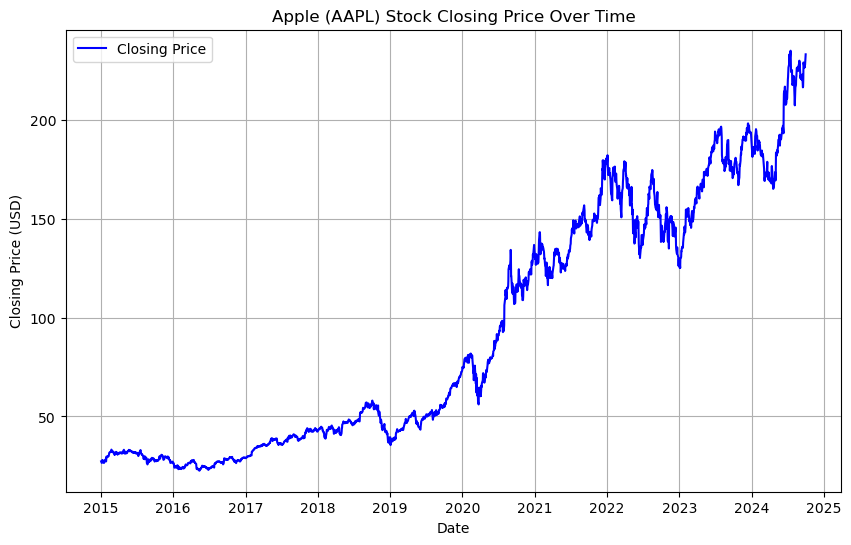

In [3]:
# Here’s the full code for plotting Apple stock’s closing price over time:
import yfinance as yf
import matplotlib.pyplot as plt

# Define the stock symbol and time range
stock_symbol = 'AAPL'
start_date = '2015-01-01'
end_date = '2024-10-01'

# Fetch the stock data using yfinance
stock_data = yf.download(stock_symbol, start=start_date, end=end_date)

# Plot the closing price over time
plt.figure(figsize=(10, 6))
plt.plot(stock_data.index, stock_data['Close'], label='Closing Price', color='blue')
plt.title('Apple (AAPL) Stock Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.grid(True)
plt.legend()
plt.show()

## 2. Data Exploration & Visualization
We’ll explore the data to understand trends and key features.
We can create visualizations like line charts to see how Apple’s stock price has changed over time.

In [4]:
import pandas as pd

# Create the 50-day and 200-day Simple Moving Averages (SMA)
stock_data['SMA_50'] = stock_data['Close'].rolling(window=50).mean()
stock_data['SMA_200'] = stock_data['Close'].rolling(window=200).mean()

# Create the 50-day Exponential Moving Average (EMA)
stock_data['EMA_50'] = stock_data['Close'].ewm(span=50, adjust=False).mean()

# Create the Relative Strength Index (RSI) - 14-day
delta = stock_data['Close'].diff(1)
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
stock_data['RSI_14'] = 100 - (100 / (1 + rs))

# Create the MACD (12-day EMA - 26-day EMA)
stock_data['EMA_12'] = stock_data['Close'].ewm(span=12, adjust=False).mean()
stock_data['EMA_26'] = stock_data['Close'].ewm(span=26, adjust=False).mean()
stock_data['MACD'] = stock_data['EMA_12'] - stock_data['EMA_26']

# Create Volatility (Standard Deviation over a 30-day window)
stock_data['Volatility_30'] = stock_data['Close'].rolling(window=30).std()

# Drop any NaN values that may have been created
stock_data = stock_data.dropna()

# Display the new columns with the features
stock_data[['SMA_50', 'SMA_200', 'EMA_50', 'RSI_14', 'MACD', 'Volatility_30']].head()


Price,SMA_50,SMA_200,EMA_50,RSI_14,MACD,Volatility_30
Ticker,,,,,,
Date,,,,,,
2015-10-16 00:00:00+00:00,28.08690,30.332337,28.419614,45.694957,-0.155139,0.541575
2015-10-19 00:00:00+00:00,28.06795,30.335337,28.400512,59.837888,-0.135251,0.523151
2015-10-20 00:00:00+00:00,28.03820,30.344737,28.402158,62.073740,-0.077445,0.526895
2015-10-21 00:00:00+00:00,28.03955,30.354112,28.403642,65.300152,-0.031472,0.518788
2015-10-22 00:00:00+00:00,28.04085,30.363800,28.422127,67.534258,0.039606,0.535866


## 3. Feature Engineering
We can create additional features like moving averages, momentum indicators, or other technical indicators.

- In stock price prediction, feature engineering is crucial for improving the performance of machine learning models. 
- Some commonly used features include moving averages, volatility, and momentum indicators. 
- Here's how we can create these features:

## Common Technical Indicators for Stock Price Prediction:

### 1- Simple Moving Average (SMA): 
 The average price over a specified period.
### 2- Exponential Moving Average (EMA): 
 A weighted average where more recent prices are given more weight.
### 3- Relative Strength Index (RSI): 
 Measures the speed and change of price movements, helping identify overbought or oversold conditions.
### 4- Moving Average Convergence Divergence (MACD): 
 A trend-following momentum indicator that shows the relationship between two moving averages.
### 5- Volatility: 
 Measures the variation of stock prices over time, indicating risk.

### Let's create the following features:
#### 1. SMA (50-day and 200-day): Commonly used moving averages to identify trends.
#### 2. EMA (50-day): To give more weight to recent data.
#### 3. RSI (14-day): To measure momentum.
#### 4. MACD: A trend-following indicator using EMA.
#### 5. Volatility: Based on standard deviation over a rolling window.

#### Here’s the code to generate these features:

Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0020
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0019
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0020
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0018
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0017
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0018
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0017
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0018
Epoch 9/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0019
Epoch 10/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0016
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


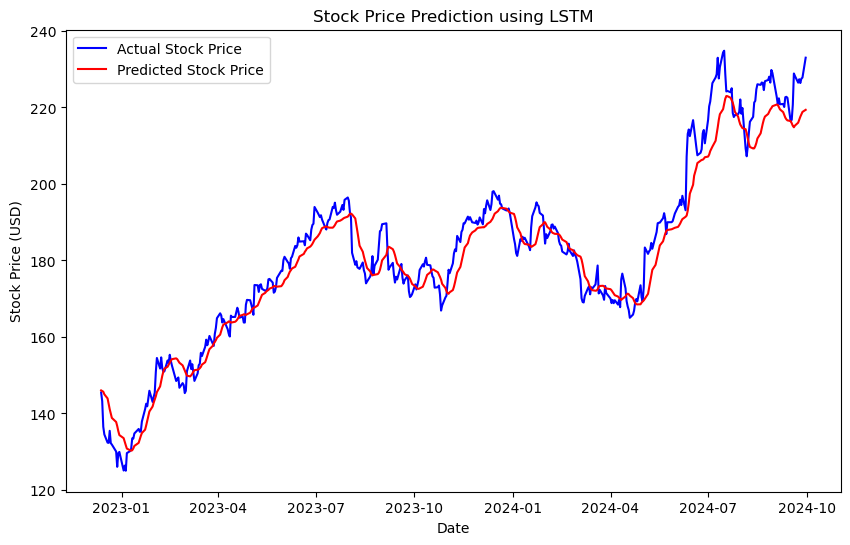

In [6]:
# Split the data into training and testing sets
train_size = int(len(stock_data) * 0.8)  # 80% of data for training
train_data = stock_data['Close'][:train_size].values.reshape(-1, 1)
test_data = stock_data['Close'][train_size - sequence_length:].values.reshape(-1, 1)

# Scale the training and testing data
scaled_train_data = scaler.fit_transform(train_data)
scaled_test_data = scaler.transform(test_data)

# Prepare the training data sequences
X_train = []
y_train = []

for i in range(sequence_length, len(scaled_train_data)):
    X_train.append(scaled_train_data[i-sequence_length:i, 0])
    y_train.append(scaled_train_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Prepare the testing data sequences
X_test = []
y_test = test_data[sequence_length:]

for i in range(sequence_length, len(scaled_test_data)):
    X_test.append(scaled_test_data[i-sequence_length:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Model Training (keep as it was)
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Predict using the trained model
predicted_stock_price = model.predict(X_test)

# Inverse transform the scaled predictions and actual prices
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

# Visualization of Predictions vs Actual Prices
plt.figure(figsize=(10,6))
plt.plot(stock_data.index[train_size:], test_data[sequence_length:], color='blue', label='Actual Stock Price')
plt.plot(stock_data.index[train_size:], predicted_stock_price, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.show()


### Explanation:
* train_size: We use 80% of the data for training and the rest for testing.
* sequence_length: The model uses the previous 60 days to predict the next day’s price.
* scaler: We scale both the training and testing data to normalize values.
* Model Training: The LSTM model is trained on the training set and used to predict stock prices on the test set.